# Regression: California Housing

## Business Goal:
**Produce estimates of house prices so that real estate agents can use that to make pricing decisions faster and more consistently.**

In [96]:
import random

import pandas as pd
from sklearn.model_selection import train_test_split

In [97]:
df = pd.read_csv("california_housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data Exploration

<AxesSubplot: >

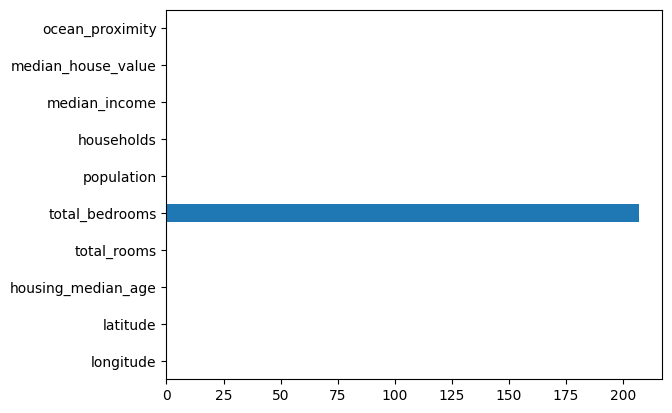

In [98]:
df.isna().sum().plot.barh()

In [99]:
df["total_bedrooms"].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

<AxesSubplot: >

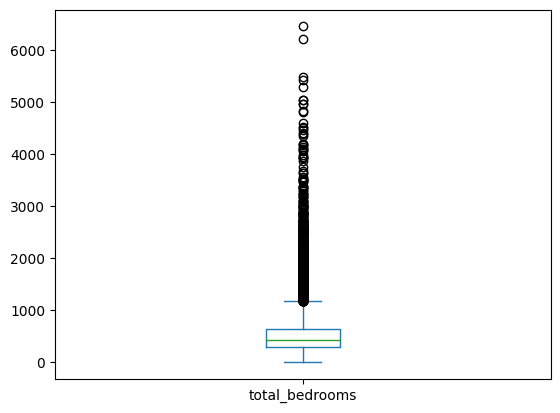

In [100]:
df["total_bedrooms"].plot.box()

### Train / Test split

In [101]:
# find out the size of the test set
df.shape[0] // 5  # 20%

4128

In [102]:
random.seed(777)  # initializes the random number generator
indices = list(range(0, df.shape[0]))
random.shuffle(indices)

training_indices = indices[:-8256]
validation_indices = indices[-8256:-4128]
test_indices = indices[-4128:]

training_indices[:10]

[6446, 1869, 13618, 6102, 19764, 16589, 5091, 4156, 14362, 10826]

In [103]:
df_train = df.iloc[training_indices].copy()  # use copies so that pandas does not spam me with warnings
df_val = df.iloc[validation_indices].copy()
df_test = df.iloc[test_indices].copy()

In [104]:
# alternative: Scikit-learn
from sklearn.model_selection import train_test_split

df_trainval, df_test2 = train_test_split(df, test_size=0.2, random_state=777)
df_train2, df_val2 = train_test_split(df_trainval, test_size=0.25)

In [105]:
df_train.shape, df_val.shape, df_test.shape  # column number must be the same!

((12384, 10), (4128, 10), (4128, 10))

In [106]:
df_train2.shape, df_val2.shape, df_test2.shape  # same numbers

((12384, 10), (4128, 10), (4128, 10))

## Feature Engineering

**ground rule in scikit: call .fit() only for training data!**

In [107]:
# idea: try label encoding and one-hot encoding on ocean_prox and see which is better

### Transform the categorical values in ocean_proximity

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
# creates one new column
encoder = LabelEncoder()  # initialize.. boring
encoder.fit(df_train["ocean_proximity"])        # see what unique values occur in the column (ONLY FOR train!!!)
df_train["ocean_label"] = encoder.transform(df_train["ocean_proximity"])  # translate the values to 0..n
df_val["ocean_label"] = encoder.transform(df_val["ocean_proximity"])
df_test["ocean_label"] = encoder.transform(df_test["ocean_proximity"])

#### Try one-hot encoding

In [110]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

### Fix missing values in total_bedrooms

In [111]:
median = df_train["total_bedrooms"].median()
df_train["total_bedrooms"].fillna(median, inplace=True)
df_val["total_bedrooms"].fillna(median, inplace=True)
df_test["total_bedrooms"].fillna(median, inplace=True)

### Identify X and y

In [112]:
# separate the target variable y (dependent variable): the thing we want to predict
y_train = df_train["median_house_value"]
y_val = df_val["median_house_value"]
y_test = df_test["median_house_value"]

In [113]:
# df_train.columns

In [219]:
# separate the predictor features X (independent variables): the things we use for predicting
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
           'ocean_proximity',
           # 'ocean_label'
          ]
X_train = df_train[columns]
X_val = df_val[columns]
X_test = df_test[columns]

### One Hot Encoding + Binning of coordinates

In [220]:
from sklearn.preprocessing import KBinsDiscretizer

In [221]:
# creates five new columns
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=False), ["ocean_proximity"]), # use OHEnc for the ocean_proximity column
        ('binning', KBinsDiscretizer(n_bins=10), ["longitude", "latitude", "population", "total_bedrooms"]),
    ],  
    remainder='passthrough'                            # do nothing to the other columns
)
ct.fit(X_train)
X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

In [222]:
X_train.shape, X_val.shape, X_test.shape

((12384, 49), (4128, 49), (4128, 49))

In [223]:
y_train.shape, y_val.shape, y_test.shape

((12384,), (4128,), (4128,))

## The Model

In [224]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [225]:
m = LinearRegression(fit_intercept=True)  # 1. initialize the model (set hyperparameters)
# m = KNeighborsRegressor(n_neighbors=5)
m.fit(X_train, y_train)                   # 2. fit the model with training data (NEVER validation or test data!)

LinearRegression()

In [226]:
y_pred = m.predict(X_train)
y_pred

array([299274.73996068,  75284.45902173, 128350.87066354, ...,
       213993.82700361, 208316.13415868, 115496.93334556])

In [227]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)

In [228]:
mean_squared_error(y_train, y_pred)  # MSE has no unit

4066664449.745836

In [229]:
y_pred_val = m.predict(X_val)
mean_squared_error(y_val, y_pred_val)

4490813731.649987

### MAE (Mean Absolute Error)

advantage: unit is the same as in the target column y

$$mae = \frac{1}{n} \sum | y_i - y_{true} |$$

In [230]:
round(mean_absolute_error(y_train, y_pred), 1)  # USD

46129.3

In [231]:
round(mean_absolute_error(y_val, y_pred_val), 1)  # USD

47480.8

## Overfitting

if your model has too much information, it will start learning the training data by heart.
Result: 
    
* good performance for training data
* bad performance for validation / test data

**ideally, your training and validation scores should be the same**

## Calculate Test Score

In [232]:
y_pred_test = m.predict(X_test)

In [233]:
mean_squared_error(y_test, y_pred_test)

4035659658.984373

In [234]:
mean_absolute_error(y_test, y_pred_test)

45806.30284211217